
### Load the necessary libraries


In [81]:
import os

import dill
import numpy as np
import jax.numpy as jnp
import pandas as pd
import geopandas as gpd

import jax
from jax import random
from jax.tree_util import tree_map  

import numpyro
from numpyro.infer import Predictive
import numpyro.distributions as dist

import arviz as az
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.pardir)

jax.config.update("jax_default_device", jax.devices()[1])
print(f"Jax using device : {jax.devices()}")

Jax using device : [CudaDevice(id=0), CudaDevice(id=1)]


### Load the necessary variables

In [59]:
# Lat/Lon Values of artificial grid
x = np.load(os.path.join("../data/processed/lat_lon_x_all.npy"))
# Low regional data
pol_pts_all = np.load("../data/processed/pol_pts_all.npy")
pt_which_pol_all = np.load("../data/processed/pt_which_pol_all.npy")
# Dataframes
df = gpd.read_file("../data/processed/final_combined_divisions/final_combined_divisions.shp")

In [60]:
#for extracting > 1 chain
# Define the correct path for model_weights (sibling folder to src)
script_dir = os.getcwd()  # Get current working directory
save_dir = os.path.abspath(os.path.join(script_dir, "..", "model_weights"))  # Move up and into model_weights

# Ensure the directory exists
if not os.path.exists(save_dir):
    raise FileNotFoundError(f"Directory '{save_dir}' does not exist. Ensure the chains were saved properly.")

n_samples = 2000  # Adjust based on your settings

# Load MCMC objects
mcmc_list = []
for chain_id in range(3):  # Since you have chains 0 to 2
    # Find all matching files for the chain
    matching_files = sorted(
        [f for f in os.listdir(save_dir) if f.startswith(f"aggGP_chain{chain_id}_nsamples_{n_samples}_tt")],
        reverse=True  # Prioritize later files in case of multiple runs
    )

    if matching_files:
        file_path = os.path.join(save_dir, matching_files[0])  # Pick the latest file
        with open(file_path, "rb") as file:
            mcmc = dill.load(file)
            mcmc_list.append(mcmc)
        print(f"Loaded Chain {chain_id} from {file_path}")
    else:
        print(f"Warning: Missing Chain {chain_id} file!")

# Ensure all chains were loaded
if len(mcmc_list) != 3:
    raise ValueError(f"Not all chains were loaded successfully! Loaded {len(mcmc_list)}/3 chains.")

# Extract samples from NumPyro MCMC objects (keeping chains separate)
extracted_samples = [mcmc.get_samples(group_by_chain=True) for mcmc in mcmc_list]

Loaded Chain 1 from /home/jupyter-jwidyawati/model_weights/aggGP_chain1_nsamples_2000_tt7min_logit.pkl


ValueError: Not all chains were loaded successfully! Loaded 1/3 chains.

In [82]:
#for extracting 1 chain to see the posterior estimation only
import os
import dill

# Define the correct path for model_weights (sibling folder to src)
script_dir = os.getcwd()  # Get current working directory
save_dir = os.path.abspath(os.path.join(script_dir, "..", "model_weights"))  # Move up and into model_weights

# Ensure the directory exists
if not os.path.exists(save_dir):
    raise FileNotFoundError(f"Directory '{save_dir}' does not exist. Ensure the chains were saved properly.")

n_samples = 2000  # Adjust based on your settings

# Load only Chain 1
chain_id = 1  
matching_files = sorted(
    [f for f in os.listdir(save_dir) if f.startswith(f"aggGP_chain{chain_id}_nsamples_{n_samples}_tt")],
    reverse=True  # Prioritize later files in case of multiple runs
)

if matching_files:
    file_path = os.path.join(save_dir, matching_files[0])  # Pick the latest file
    with open(file_path, "rb") as file:
        mcmc = dill.load(file)
    print(f"Loaded Chain {chain_id} from {file_path}")
else:
    raise FileNotFoundError(f"Error: Missing Chain {chain_id} file!")

# Extract samples from the NumPyro MCMC object
extracted_samples = mcmc.get_samples(group_by_chain=True)

Loaded Chain 1 from /home/jupyter-jwidyawati/model_weights/aggGP_chain1_nsamples_2000_tt1388min_logit.pkl


### Check diagnostics

In [71]:
# Combine all chains into one using tree_map
combined_samples = tree_map(lambda *x: np.concatenate(x, axis=0), *extracted_samples)

# Compute diagnostics
ss = numpyro.diagnostics.summary(combined_samples)

# Print diagnostics
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")
print(f"Max r_hat for all aggGP effects : {round(np.max(ss['gp_aggr']['r_hat']),2)}")
print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 1
Max r_hat for all aggGP effects : 1.0
kernel_length R-hat : 1.0
kernel_var R-hat : nan


/home/jupyter-jwidyawati/.local/lib/python3.10/site-packages/numpyro/diagnostics.py:184: RuntimeWarning: invalid value encountered in divide
  rho_k = 1.0 - (var_within - gamma_k_c.mean(axis=0)) / var_estimator


In [83]:
#check for one chain only
# Compute diagnostics
ss = numpyro.diagnostics.summary(extracted_samples)

# Print diagnostics
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")
print(f"Max r_hat for all aggGP effects : {round(np.max(ss['gp_aggr']['r_hat']),2)}")
print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 4
Max r_hat for all aggGP effects : 3.4800000190734863
kernel_length R-hat : 1.3700000047683716
kernel_var R-hat : nan


In [84]:
#Plots
# Convert to ArviZ InferenceData format
idata = az.from_dict(posterior=extracted_samples)

ValueError: Too many bins for data range. Cannot create 512 finite-sized bins.

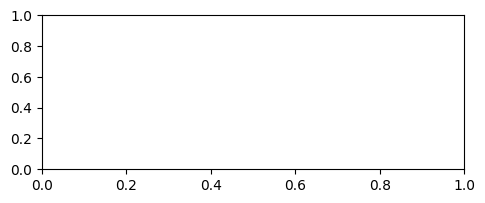

In [85]:
#trace plot (check mixing)
az.plot_trace(idata, var_names = "kernel_length")
az.plot_trace(idata, var_names = "kernel_var")

/home/jupyter-jwidyawati/.local/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7501) in plot_rank, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'b0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'b_hdi'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'b_pop_density'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'f\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'f\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n8'}, xla

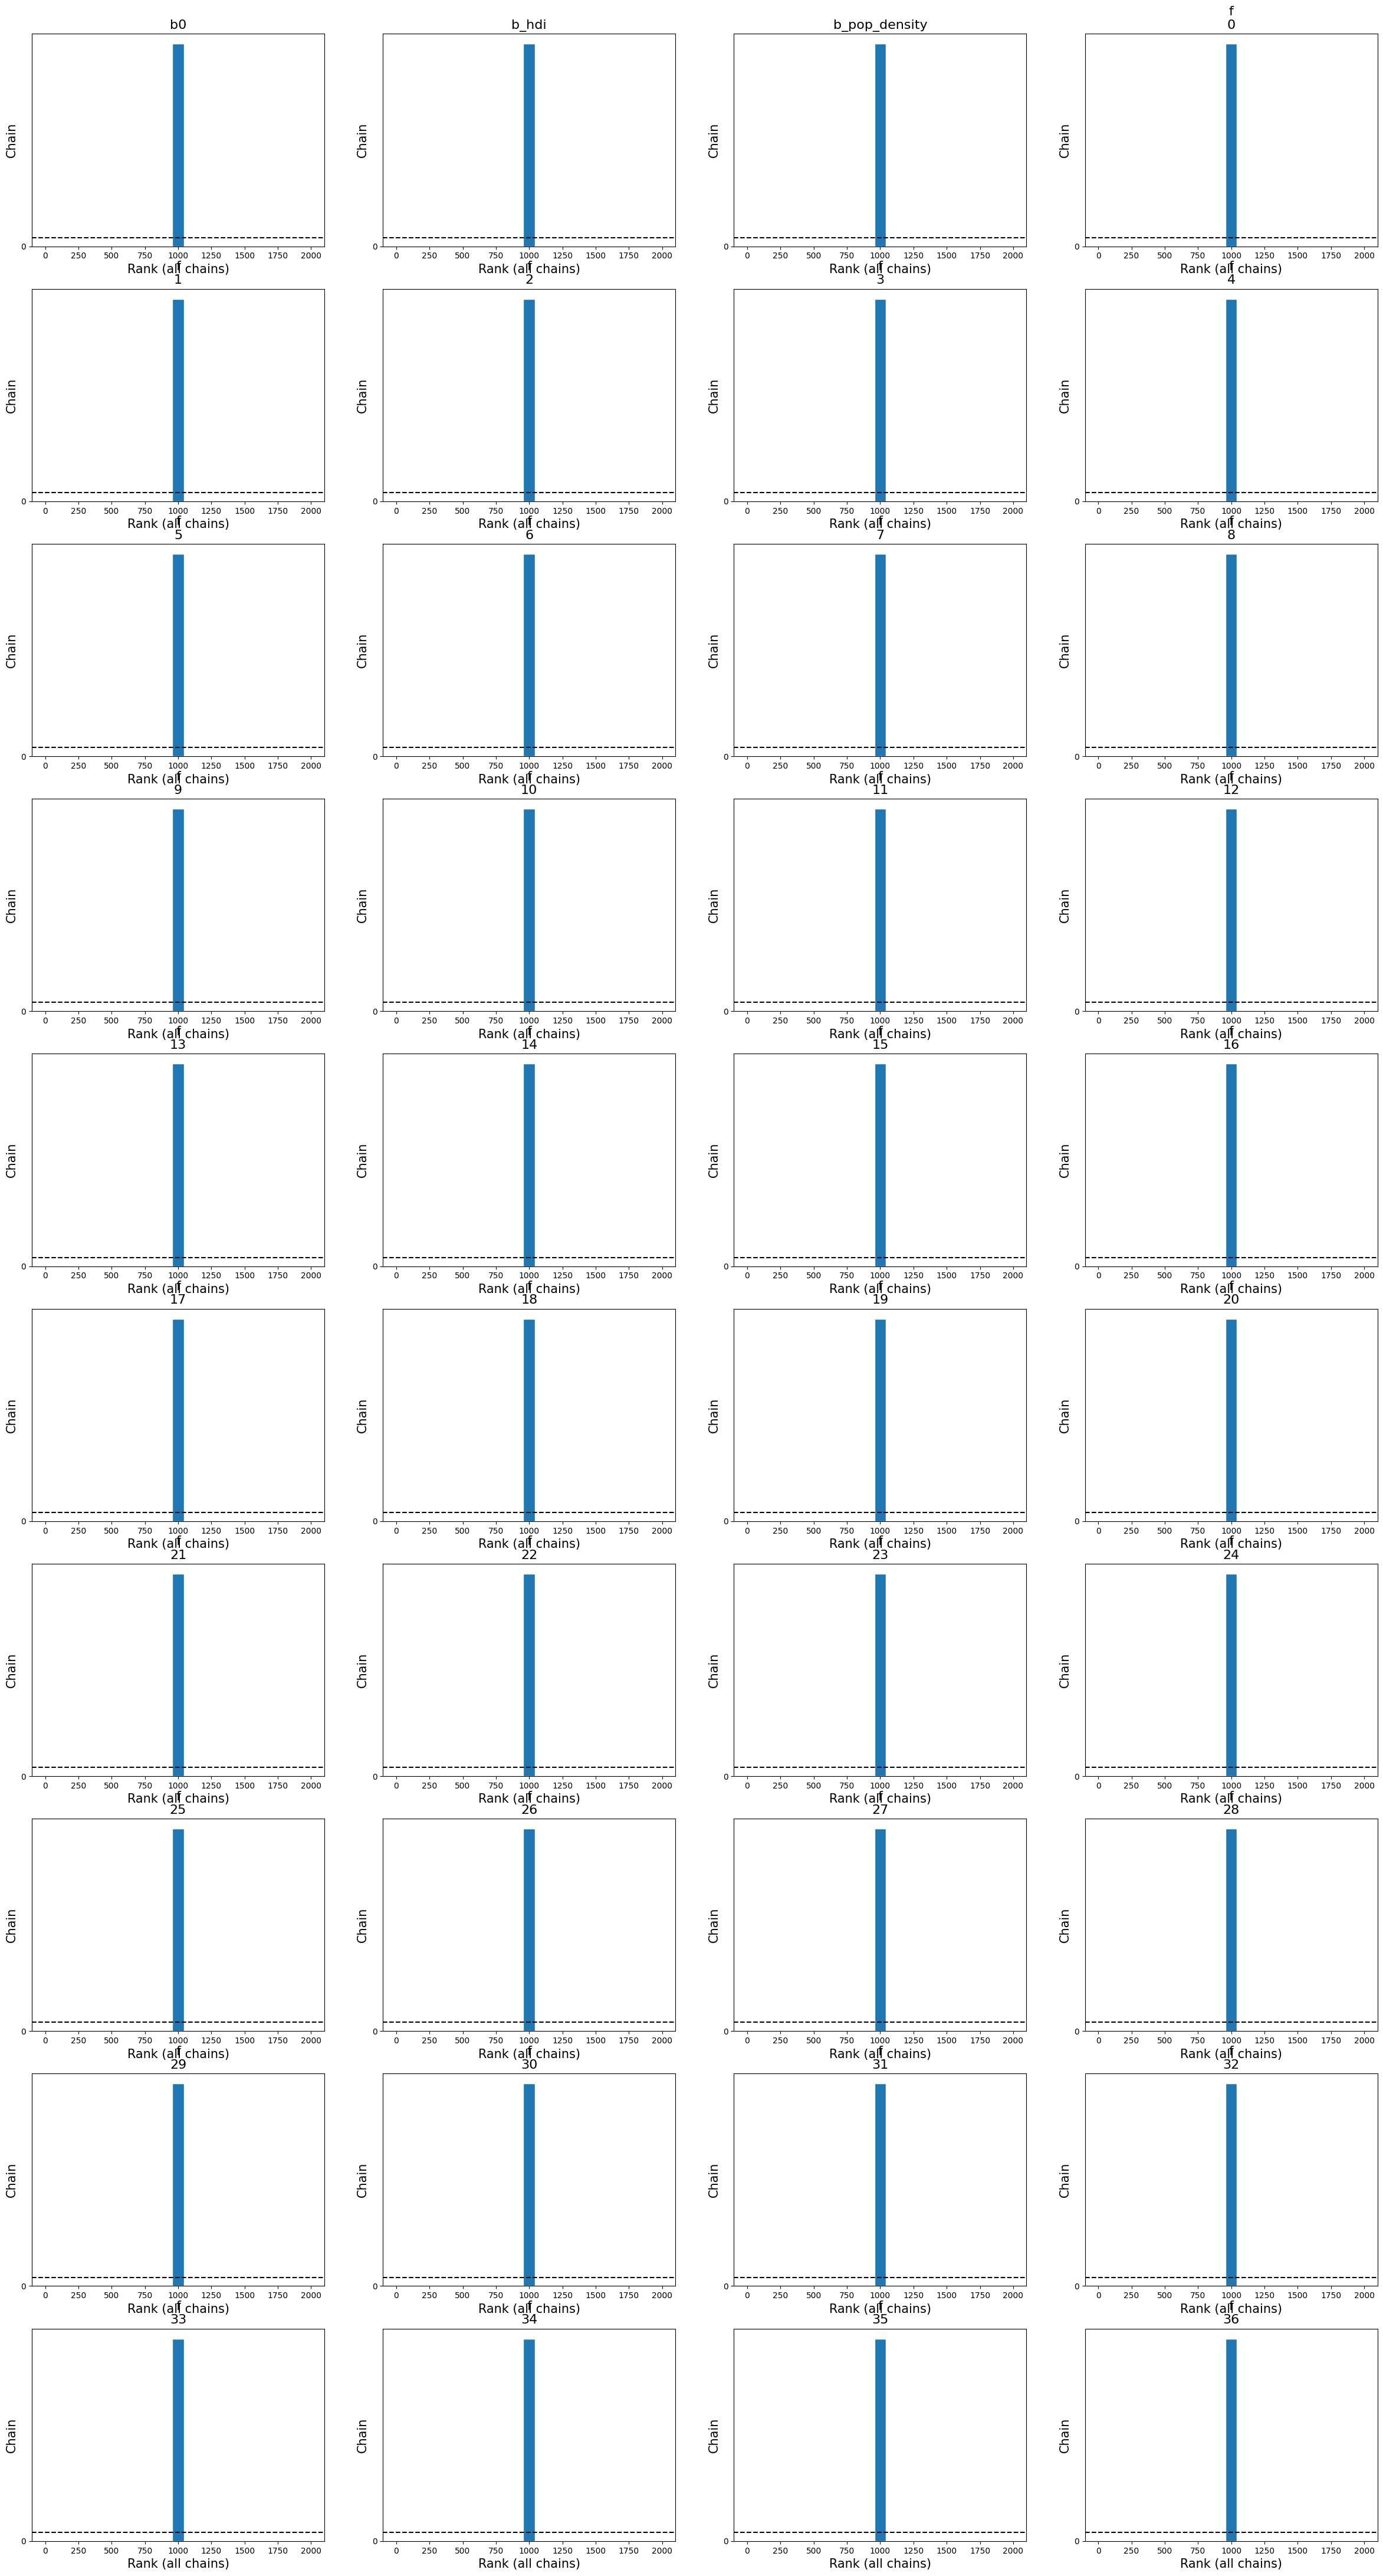

In [76]:
#rank plot (ensure good mixing across chains)
az.plot_rank(idata)

In [77]:
# Extract posterior samples (already combined)
pos_samples = idata.posterior

# Print MCMC summary
print(az.summary(idata, var_names=["gp_aggr", "kernel_length", "kernel_var"]))

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                 mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
gp_aggr[0]     31.152  0.0  31.151   31.151        0.0      0.0    2000.0   
gp_aggr[1]     31.152  0.0  31.151   31.151        0.0      0.0    2000.0   
gp_aggr[2]     31.152  0.0  31.151   31.151        0.0      0.0    2000.0   
gp_aggr[3]     31.152  0.0  31.151   31.151        0.0      0.0    2000.0   
gp_aggr[4]     -7.609  0.0  -7.609   -7.609        0.0      0.0    2000.0   
...               ...  ...     ...      ...        ...      ...       ...   
gp_aggr[93]   -11.743  0.0 -11.743  -11.743        0.0      NaN    2000.0   
gp_aggr[94]   -11.743  0.0 -11.743  -11.743        0.0      NaN    2000.0   
gp_aggr[95]   -11.743  0.0 -11.743  -11.743        0.0      NaN    2000.0   
kernel_length   0.558  0.0   0.558    0.558        0.0      0.0    2000.0   
kernel_var      0.530  0.0   0.530    0.530        0.0      NaN    2000.0   

               ess_tail  r_hat  
gp_aggr[0]       2000.0    NaN  
gp_aggr[1

/home/jupyter-jwidyawati/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


### Extract prevalence estimate and observed prevalence data from the posterior and combine it into existing df

In [86]:
#extract the theta estimate (dengue prevalence probability)
combined_samples["theta"].shape

(3, 2000, 96)

In [87]:
print(combined_samples["theta"])

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


In [21]:
theta_mean_gp = combined_samples["theta"].mean(axis = (0, 1))
bci_gp_25 = np.quantile(combined_samples["theta"],0.25,axis = (0, 1))
bci_gp_75 = np.quantile(combined_samples["theta"],0.75, axis = (0, 1))

In [22]:
#create the column to store theta estimate by gp into df
df["theta_gp"] = theta_mean_gp

# Calculate Prevalence
df["obs_prev"] = df.apply(lambda row: row.Cases / row.Population, axis = 1)

theta_obs = df["obs_prev"]
theta_gp_est = df["theta_gp"]
_max = np.max([theta_obs, theta_gp_est])
_min = np.min([theta_obs, theta_gp_est])

In [23]:
#check the df head
df.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_densit,geometry,theta_gp,obs_prev
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1.0,0.000633
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1.0,0.000546
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1.0,0.001130
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1.0,0.000268
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",1.0,0.000540


Text(0.5, 1.0, 'Observed Dengue Prevalance')

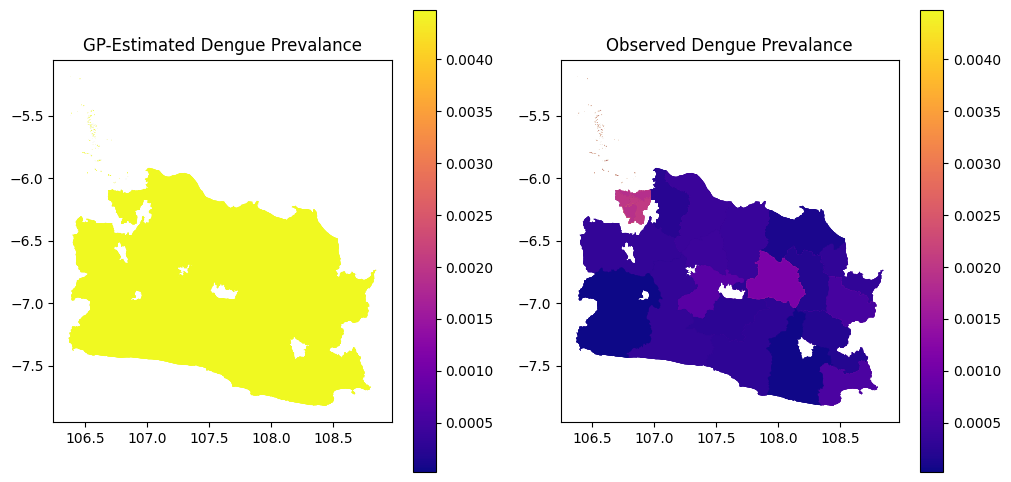

In [30]:
#plot the observed prevalence vs gp-estimated prevalence
fig,ax = plt.subplots(1,2, figsize = (12,6))
df.plot(column = "theta_gp", ax = ax[0], legend = True, cmap = "plasma", vmin = _min, vmax = _max)
df.plot(column = "obs_prev", ax = ax[1], legend = True, cmap = "plasma", vmax = _max, vmin = _min)

ax[0].set_title("GP-Estimated Dengue Prevalance")
ax[1].set_title("Observed Dengue Prevalance")

Text(0.5, 1.0, 'Observed Dengue Prevalence')

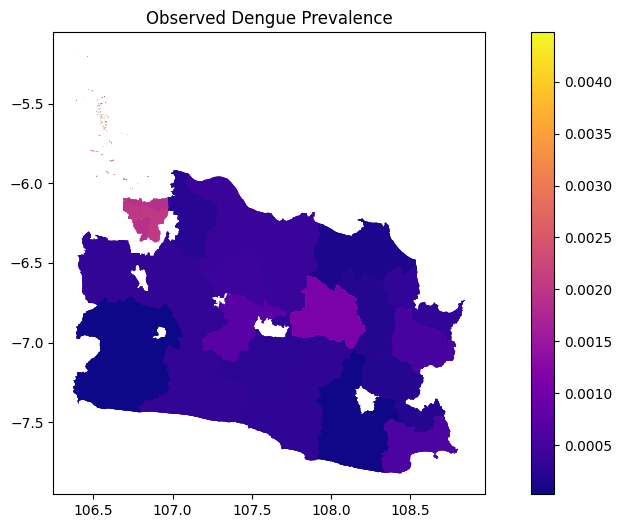

In [33]:
#plot the observed prevalence only
fig,ax = plt.subplots(1, figsize = (12,6))

_nmax = np.max([theta_obs])
_nmin = np.min([theta_obs])

df.plot(column = "obs_prev", ax = ax, legend = True, cmap = "plasma", vmax = _nmax, vmin = _nmin)

ax.set_title("Observed Dengue Prevalence")

Text(0.5, 1.0, 'Observations using aggVAE Priors')

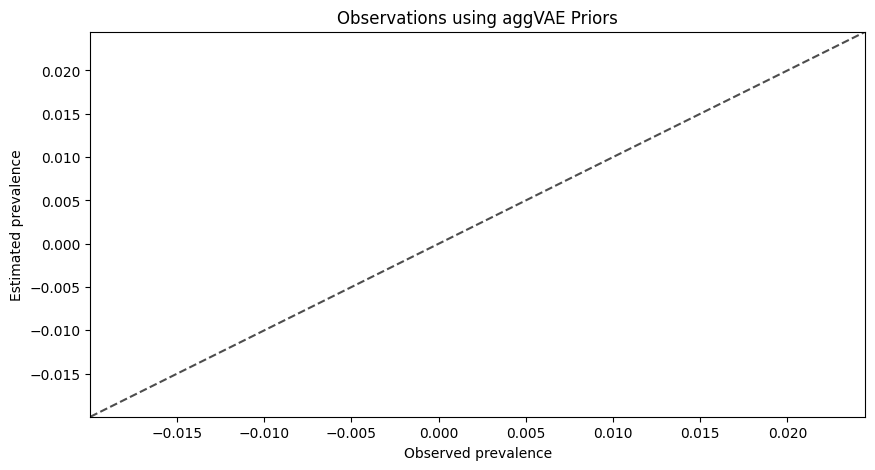

In [35]:
#scatterplot
fig, ax = plt.subplots(1, figsize=(10,5))

ax.scatter(df['obs_prev'], df['theta_gp'])
ax.set_ylim(_min-0.02, _max+0.02)
ax.set_xlim(_min-0.02, _max+0.02)
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.set_xlabel("Observed prevalence")
ax.set_ylabel("Estimated prevalence")
ax.set_title("Observations using aggVAE Priors")